In [20]:
import zipfile
import pandas as pd
import os

# Define the path to the zip file
zip_file_path = '/content/human_vital_signs_dataset_2024.csv.zip'  # Updated path

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: zip file not found at {zip_file_path}")
else:
    # Create a directory to extract the contents
    extraction_path = '/extracted_data'
    os.makedirs(extraction_path, exist_ok=True)

    # Extract the contents of the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
            extracted_files = zip_ref.namelist()  # Get a list of extracted file names
        print(f"Extracted {len(extracted_files)} files to {extraction_path}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"Error during extraction: {e}")

    # After extraction, list files in the directory to find CSV files
    if os.path.exists(extraction_path):
        all_files = os.listdir(extraction_path)
        csv_files = [f for f in all_files if f.lower().endswith('.csv')]

        if not csv_files:
            print(f"Error: No CSV files found in the extracted directory {extraction_path}")
        else:
            # Display head of the vital signs dataset
            csv_file_path = os.path.join(extraction_path, csv_files[0])
            try:
                vital_signs_df = pd.read_csv(csv_file_path)
                print(f"\n--- Head of Human Vital Signs Dataset --- (Path: {csv_file_path})")
                print(vital_signs_df.head().to_markdown(index=False, numalign="left", stralign="left"))

                # Display basic info about the dataset
                print(f"\n--- Dataset Info ---")
                print(f"Number of rows: {vital_signs_df.shape[0]}")
                print(f"Number of columns: {vital_signs_df.shape[1]}")
                print(f"Columns: {', '.join(vital_signs_df.columns)}")
            except Exception as e:
                print(f"Error reading CSV file ({csv_files[0]}): {e}")
    else:
        print("Extraction directory not found. Please check the extraction process.")

Extracted 1 files to /extracted_data

--- Head of Human Vital Signs Dataset --- (Path: /extracted_data/human_vital_signs_dataset_2024.csv)
| Patient ID   | Heart Rate   | Respiratory Rate   | Timestamp                  | Body Temperature   | Oxygen Saturation   | Systolic Blood Pressure   | Diastolic Blood Pressure   | Age   | Gender   | Weight (kg)   | Height (m)   | Derived_HRV   | Derived_Pulse_Pressure   | Derived_BMI   | Derived_MAP   | Risk Category   |
|:-------------|:-------------|:-------------------|:---------------------------|:-------------------|:--------------------|:--------------------------|:---------------------------|:------|:---------|:--------------|:-------------|:--------------|:-------------------------|:--------------|:--------------|:----------------|
| 1            | 60           | 12                 | 2024-07-19 21:53:45.729841 | 36.8617            | 95.702              | 124                       | 86                         | 37    | Female   | 91.5416   

In [1]:
!pip install tqdm

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
from tqdm import tqdm  # ADD THIS

# Load the dataset
input_path = "/extracted_data/human_vital_signs_dataset_2024.csv"
df = pd.read_csv(input_path)

# Process patients
test_patients = int(200020 / 10)
rows_list = []

# Wrap the loop with tqdm for progress bar
for patient_idx in tqdm(range(test_patients), desc="Processing Patients"):
    base_idx = patient_idx * 10
    if base_idx >= len(df):
        break

    first_row = df.iloc[base_idx]
    gender = first_row['Gender']
    base_timestamp = datetime.strptime(first_row['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')
    base_age = first_row['Age']
    patient_id = first_row['Patient ID']

    for year_offset in range(10):
        idx = base_idx + year_offset
        if idx >= len(df):
            break

        row = df.iloc[idx].to_dict()

        # Update fields
        row['Patient ID'] = patient_id
        row['Gender'] = gender
        new_timestamp = base_timestamp.replace(year=base_timestamp.year + year_offset)
        row['Timestamp'] = new_timestamp.strftime('%Y-%m-%d %H:%M:%S.%f')
        row['Age'] = base_age + year_offset

        rows_list.append(row)

# Convert once at the end
transformed_df = pd.DataFrame(rows_list)

# Drop Height (m) column
transformed_df = transformed_df.drop(columns=['Height (m)'])

# Condense patients
condensed_rows = []
measures = [col for col in transformed_df.columns if col not in ['Patient ID', 'Gender', 'Timestamp']]

grouped = transformed_df.sort_values('Timestamp').groupby('Patient ID')

# tqdm for condensing too
for patient_id, patient_data in tqdm(grouped, desc="Condensing Patients", total=len(grouped)):
    new_row = {
        'Patient ID': patient_id,
        'Gender': patient_data['Gender'].iloc[0]
    }

    for measure in measures:
        measure_values = patient_data[measure].values
        for i in range(len(measure_values)):
            new_row[f'{measure}_Year_{i+1}'] = measure_values[i]

    condensed_rows.append(new_row)

condensed_df = pd.DataFrame(condensed_rows)

# Output
output_dir = "/transformed_data"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "condensed_vital_signs_dataset.csv")
condensed_df.to_csv(output_path, index=False)

print(f"Condensed dataset created with {len(condensed_df)} rows.")
print("Sample of condensed data:")
print(condensed_df.head(5))
print(condensed_df.shape)

Condensing Patients: 100%|██████████| 20002/20002 [00:07<00:00, 2830.25it/s]


Condensed dataset created with 20002 rows.
Sample of condensed data:
   Patient ID  Gender  Heart Rate_Year_1  Heart Rate_Year_2  \
0           1  Female                 60                 63   
1          11  Female                 84                 84   
2          21    Male                 85                 73   
3          31  Female                 95                 84   
4          41  Female                 92                 91   

   Heart Rate_Year_3  Heart Rate_Year_4  Heart Rate_Year_5  Heart Rate_Year_6  \
0                 63                 99                 69                 79   
1                 72                 61                 98                 99   
2                 68                 69                 80                 76   
3                 89                 79                 79                 74   
4                 70                 83                 95                 71   

   Heart Rate_Year_7  Heart Rate_Year_8  ...  Risk Category_Year_

In [3]:
print(df.columns.tolist())

['Patient ID', 'Heart Rate', 'Respiratory Rate', 'Timestamp', 'Body Temperature', 'Oxygen Saturation', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI', 'Derived_MAP', 'Risk Category']


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("/transformed_data/condensed_vital_signs_dataset.csv")
print(f"Original dataset shape: {df.shape}")

df['Risk_Category_Binary'] = df['Risk Category_Year_10'].apply(lambda x: 1 if x == 'High Risk' else 0)
print(df['Risk_Category_Binary'])
risk_category_cols = [col for col in df.columns if col.startswith('Risk Category_Year_')]
df = df.drop(columns=risk_category_cols)

data_target = df['Risk_Category_Binary']
data_features = df.drop(['Risk_Category_Binary'], axis=1)

Original dataset shape: (20002, 132)
0        1
1        1
2        0
3        1
4        0
        ..
19997    0
19998    1
19999    1
20000    0
20001    0
Name: Risk_Category_Binary, Length: 20002, dtype: int64


In [5]:
data_target.value_counts()

,count
Risk_Category_Binary,
1,10568
0,9434


In [6]:
data_features.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
Patient ID,Gender,Heart Rate_Year_1,Heart Rate_Year_2,Heart Rate_Year_3,Heart Rate_Year_4,Heart Rate_Year_5,Heart Rate_Year_6,Heart Rate_Year_7,Heart Rate_Year_8,Heart Rate_Year_9,Heart Rate_Year_10,Respiratory Rate_Year_1,Respiratory Rate_Year_2,Respiratory Rate_Year_3,Respiratory Rate_Year_4,Respiratory Rate_Year_5,Respiratory Rate_Year_6,Respiratory Rate_Year_7,Respiratory Rate_Year_8,Respiratory Rate_Year_9,Respiratory Rate_Year_10,Body Temperature_Year_1,Body Temperature_Year_2,Body Temperature_Year_3,Body Temperature_Year_4,Body Temperature_Year_5,Body Temperature_Year_6,Body Temperature_Year_7,Body Temperature_Year_8,Body Temperature_Year_9,Body Temperature_Year_10,Oxygen Saturation_Year_1,Oxygen Saturation_Year_2,Oxygen Saturation_Year_3,Oxygen Saturation_Year_4,Oxygen Saturation_Year_5,Oxygen Saturation_Year_6,Oxygen Saturation_Year_7,Oxygen Saturation_Year_8,Oxygen Saturation_Year_9,Oxygen Saturation_Year_10,Systolic Blood Pressure_Year_1,Systolic Blood Pressure_Year_2,Systolic Blood Pressure_Year_3,Systolic Blood Pressure_Year_4,Systolic Blood Pressure_Year_5,Systolic Blood Pressure_Year_6,Systolic Blood Pressure_Year_7,Systolic Blood Pressure_Year_8,Systolic Blood Pressure_Year_9,Systolic Blood Pressure_Year_10,Diastolic Blood Pressure_Year_1,Diastolic Blood Pressure_Year_2,Diastolic Blood Pressure_Year_3,Diastolic Blood Pressure_Year_4,Diastolic Blood Pressure_Year_5,Diastolic Blood Pressure_Year_6,Diastolic Blood Pressure_Year_7,Diastolic Blood Pressure_Year_8,Diastolic Blood Pressure_Year_9,Diastolic Blood Pressure_Year_10,Age_Year_1,Age_Year_2,Age_Year_3,Age_Year_4,Age_Year_5,Age_Year_6,Age_Year_7,Age_Year_8,Age_Year_9,Age_Year_10,Weight (kg)_Year_1,Weight (kg)_Year_2,Weight (kg)_Year_3,Weight (kg)_Year_4,Weight (kg)_Year_5,Weight (kg)_Year_6,Weight (kg)_Year_7,Weight (kg)_Year_8,Weight (kg)_Year_9,Weight (kg)_Year_10,Derived_HRV_Year_1,Derived_HRV_Year_2,Derived_HRV_Year_3,Derived_HRV_Year_4,Derived_HRV_Year_5,Derived_HRV_Year_6,Derived_HRV_Year_7,Derived_HRV_Year_8,Derived_HRV_Year_9,Derived_HRV_Year_10,Derived_Pulse_Pressure_Year_1,Derived_Pulse_Pressure_Year_2,Derived_Pulse_Pressure_Year_3,Derived_Pulse_Pressure_Year_4,Derived_Pulse_Pressure_Year_5,Derived_Pulse_Pressure_Year_6,Derived_Pulse_Pressure_Year_7,Derived_Pulse_Pressure_Year_8,Derived_Pulse_Pressure_Year_9,Derived_Pulse_Pressure_Year_10,Derived_BMI_Year_1,Derived_BMI_Year_2,Derived_BMI_Year_3,Derived_BMI_Year_4,Derived_BMI_Year_5,Derived_BMI_Year_6,Derived_BMI_Year_7,Derived_BMI_Year_8,Derived_BMI_Year_9,Derived_BMI_Year_10,Derived_MAP_Year_1,Derived_MAP_Year_2,Derived_MAP_Year_3,Derived_MAP_Year_4,Derived_MAP_Year_5,Derived_MAP_Year_6,Derived_MAP_Year_7,Derived_MAP_Year_8,Derived_MAP_Year_9,Derived_MAP_Year_10,
200011,Female,83,96,99,72,99,87,76,81,83,69,13,15,19,15,18,17,16,13,13,14,36.889018,36.265847,36.395335,36.483258,36.162060,37.058905,36.463631,36.665477,37.019873,37.012931,98.472399,98.288002,98.914781,97.247410,99.987020,95.357470,99.340786,98.120530,95.362426,99.523058,137,135,136,120,135,120,131,124,125,133,85,70,70,86,72,84,89,89,86,78,18,19,20,21,22,23,24,25,26,27,94.936564,52.272303,56.789551,94.399366,95.845558,63.496314,99.384322,71.771830,60.220388,91.442825,0.052578,0.118360,0.102772,0.075562,0.112086,0.129698,0.061232,0.097381,0.068300,0.096521,52,65,66,34,63,36,42,35,39,55,40.264548,21.442918,18.819851,33.199521,26.016457,18.587394,25.145064,19.508780,17.375810,26.622442,102.333333,91.666667,92.000000,97.333333,93.000000,96.000000,103.000000,100.666667,99.000000,96.333333,1
1,Female,60,63,63,99,69,79,81,96,83,66,12,18,15,16,16,12,17,15,12,15,36.861707,36.511633,37.052049,36.654748,36.975098,36.884979,37.273640,36.852633,36.044191,36.957178,95.702046,96.689413,98.508265,95.011801,98.623792,95.987129,99.456716,97.124125,98.584497,97.916267,124,126,131,118,138,130,118,135,111,131,86,84,78,72,76,70,84,77

In [7]:
#Function to check if a column is numeric
def is_numeric_column(df, column):
    try:
        pd.to_numeric(df[column])
        return True
    except (ValueError, TypeError):
        return False

def create_time_series_features(df):
    cols = df.columns
    feature_cols = [col for col in cols if '_Year_' in col]
    numeric_feature_cols = [col for col in feature_cols if is_numeric_column(df, col)]

    year_groups = {}
    for year in range(1, 11):
        year_cols = [col for col in numeric_feature_cols if f'_Year_{year}' in col]
        if year_cols:
            year_groups[year] = year_cols

    return year_groups, numeric_feature_cols

year_groups, all_feature_cols = create_time_series_features(data_features)
print(f"Found {len(all_feature_cols)} numeric feature columns")

X_cols = []
for year in range(1, 10):
    if year in year_groups:
        X_cols.extend(year_groups[year])


X = data_features[X_cols]
y = data_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling completed successfully")

print(data_target.value_counts())

Found 120 numeric feature columns
Training set: (16001, 120), Test set: (4001, 120)
Scaling completed successfully
Risk_Category_Binary
1    10568
0     9434
Name: count, dtype: int64


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# Assuming df, data_features, data_target are already prepared

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# --- Train/Test Split ---
X = data_features
y = data_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_test.value_counts()

,count
Risk_Category_Binary,
1,2106
0,1895


In [31]:
non_numeric_cols = ['Patient ID', 'Gender']
X = data_features.drop(columns=non_numeric_cols)
y = data_target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build Classifier Pipeline ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Train
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

count of ones 2104

Accuracy: 0.9995001249687578
ROC AUC Score: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1895
           1       1.00      1.00      1.00      2106

    accuracy                           1.00      4001
   macro avg       1.00      1.00      1.00      4001
weighted avg       1.00      1.00      1.00      4001


Confusion Matrix:
[[1895    0]
 [   2 2104]]


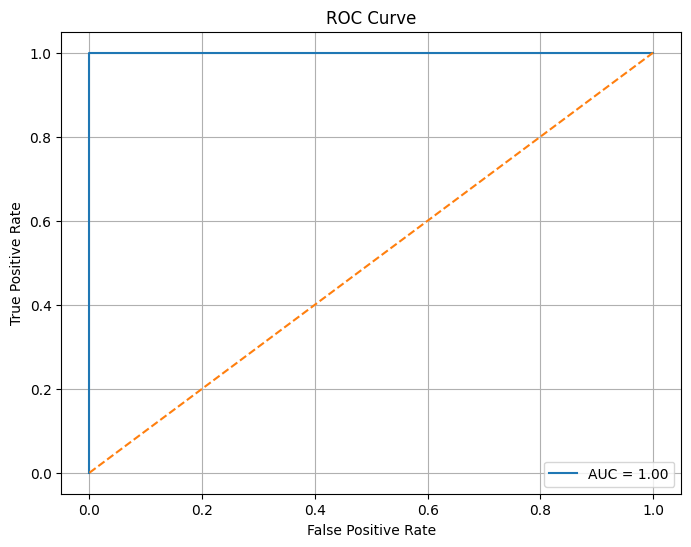

Predicted Class for Patient 1: 1 (Probability of High Risk: 0.71)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
# --- Evaluate ---

y_pred = best_model.predict(X_test)


y_pred_prob = best_model.predict_proba(X_test)[:,1]  # probability needed for ROC AUC

ones = (y_pred.nonzero())
print("count of ones", len(ones[0]))
print()

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {acc}")
print(f"ROC AUC Score: {roc_auc}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

def plot_patient_prediction(patient_id, model, scaler):
    patient_data = df[df['Patient ID'] == patient_id]

    if len(patient_data) == 0:
        print(f"Patient {patient_id} not found.")
        return

    risk_category_cols = [col for col in patient_data.columns if col.startswith('Risk Category_Year_') or col == 'Risk_Category_Binary']
    patient_features = patient_data.drop(columns=risk_category_cols)

    X_patient = patient_features[X_cols].values
    X_patient_scaled = scaler.transform(X_patient)

    prediction_prob = model.predict_proba(X_patient_scaled)[0][1]
    prediction_class = model.predict(X_patient_scaled)[0]

    print(f"Predicted Class for Patient {patient_id}: {prediction_class} (Probability of High Risk: {prediction_prob:.2f})")

sample_patient_id = df['Patient ID'].iloc[0]
plot_patient_prediction(sample_patient_id, best_model.named_steps['model'], best_model.named_steps['scaler'])

In [19]:
target_columns = [col for col in condensed_df.columns if col.startswith('data_target_')]

patients_with_zero_target = condensed_df[
    (condensed_df[target_columns] == 0).any(axis=1)
]['Patient ID']

print("Patient IDs with data_target = 0 in any year:")
print(patients_with_zero_target.tolist())

print(f"Total patients with data_target == 0: {len(patients_with_zero_target)}")

Patient IDs with data_target = 0 in any year:
[]
Total patients with data_target == 0: 0


In [43]:
# print(df.head())
print(df['Patient ID'])
sample_patient_id = df['Patient ID'].iloc[45]
plot_patient_prediction(sample_patient_id, best_model.named_steps['model'], best_model.named_steps['scaler'])

0             1
1            11
2            21
3            31
4            41
          ...  
19997    199971
19998    199981
19999    199991
20000    200001
20001    200011
Name: Patient ID, Length: 20002, dtype: int64
Predicted Class for Patient 451: 1 (Probability of High Risk: 0.74)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [44]:
from joblib import dump, load

dump(best_model, 'Quantitative_model_pipeline.joblib')

['Quantitative_model_pipeline.joblib']

In [46]:
loaded_model = load('Quantitative_model_pipeline.joblib')

In [47]:
from google.colab import files
files.download('Quantitative_model_pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [252]:
def generate_random_patient(patient_id, gender='Male'):
    row = {
        'Patient ID': patient_id,
        'Gender': gender,
    }
    for year in range(1, 11):
        row[f'Heart Rate_Year_{year}'] = np.random.randint(30, 200)  # Very wide heart rate range
        row[f'Respiratory Rate_Year_{year}'] = np.random.randint(5, 60)  # Abnormal breathing rates
        row[f'Body Temperature_Year_{year}'] = np.round(np.random.uniform(30.0, 42.0), 2)  # Hypo to hyperthermia
        row[f'Oxygen Saturation_Year_{year}'] = np.random.randint(50, 100)  # Very low to normal oxygen
        row[f'Systolic Blood Pressure_Year_{year}'] = np.random.randint(50, 250)  # Hypotension to hypertension
        row[f'Diastolic Blood Pressure_Year_{year}'] = np.random.randint(30, 150)  # Same
        row[f'Age_Year_{year}'] = np.random.randint(0, 120)  # 0-120 years
        row[f'Weight (kg)_Year_{year}'] = np.round(np.random.uniform(3.0, 200.0), 1)  # Baby to heavy adult
        row[f'Derived_HRV_Year_{year}'] = np.round(np.random.uniform(0.01, 1.0), 6)  # Very random HRV
        row[f'Derived_Pulse_Pressure_Year_{year}'] = np.random.randint(10, 150)  # Crazy pulse pressure
        row[f'Derived_BMI_Year_{year}'] = np.round(np.random.uniform(10, 60), 1)  # Very thin to morbidly obese
        row[f'Derived_MAP_Year_{year}'] = np.round(np.random.uniform(30, 160), 1)  # MAP extreme values
    return row

import pandas as pd
import numpy as np
from joblib import load

sample_patient_df = pd.DataFrame([generate_random_patient(10)])

print("=== Random Patient Data ===")
print(sample_patient_df.transpose())

loaded_model = load('Quantitative_model_pipeline.joblib')

expected_features = loaded_model.feature_names_in_
sample_features = sample_patient_df.drop(columns=['Patient ID', 'Gender'])
sample_features = sample_features.reindex(columns=expected_features).fillna(0)

sample_predictions = loaded_model.predict(sample_features)

sample_patient_df['Predicted_Label'] = sample_predictions

print(sample_patient_df[['Patient ID', 'Gender', 'Predicted_Label']])

year_10_columns = [col for col in sample_patient_df.columns if col.endswith('_Year_10')]

year_10_df = sample_patient_df[year_10_columns]

value_counts_year_10 = year_10_df.value_counts()

print(value_counts_year_10)

=== Random Patient Data ===
                                      0
Patient ID                           10
Gender                             Male
Heart Rate_Year_1                    65
Respiratory Rate_Year_1              58
Body Temperature_Year_1           36.22
...                                 ...
Weight (kg)_Year_10               176.5
Derived_HRV_Year_10             0.60093
Derived_Pulse_Pressure_Year_10       57
Derived_BMI_Year_10                46.0
Derived_MAP_Year_10               114.1

[122 rows x 1 columns]
   Patient ID Gender  Predicted_Label
0          10   Male                1
Heart Rate_Year_10  Respiratory Rate_Year_10  Body Temperature_Year_10  Oxygen Saturation_Year_10  Systolic Blood Pressure_Year_10  Diastolic Blood Pressure_Year_10  Age_Year_10  Weight (kg)_Year_10  Derived_HRV_Year_10  Derived_Pulse_Pressure_Year_10  Derived_BMI_Year_10  Derived_MAP_Year_10
194                 57                        40.23                     99                        